### 0.1 Import Package

In [1]:
import os
import re
import sys
import copy
import time
import umap.umap_ as umap
from pyprnt import prnt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings("ignore")
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import utils
from torchvision import datasets, models, transforms
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

device = torch.device("cuda:0")

PyTorch Version:  1.13.1
Torchvision Version:  0.14.1


### 0.2. Directory Setting

In [2]:
# from model.models import Conv4
from model.pretrained_models import get_pretrain_model
from dataset_dir.datasets import datasetload

In [9]:
MODEL_DIR = "./model/weight/"
LOG_DIR = "./results/log/"

**Specific model setting**: 특정한 모델을 확인하기 위해

In [10]:
RECURSIVE = False

conf = dict(
    epoch=100,
    lr=0.001,
    stepsize=50,
    gamma=0.1,
    model="alexnet",
    dataset="cifar10",
    pretrain=False,
    mode="cus",
    freeze="10111"
)
setting = "epoch"+str(conf['epoch'])+"_lr"+str(conf['lr'])

if conf["pretrain"] :
    name = "pretrain/"+str(conf['model'])+"/"+str(conf['dataset'])+"_"+setting
else :
    if str(conf["mode"]) == "cus":
        setting += "_freeze"+str(conf['freeze'])+"111"
        name = "custom/"+str(conf['model'])+"/"+str(conf['dataset'])+"_"+setting
    else :
        name = "optimal/"+str(conf['model'])+"/"+str(conf['dataset'])+"_"+setting
model_path = MODEL_DIR + name +".pt"
log_path = LOG_DIR +  name


print(model_path)
print(log_path)

./model/weight/custom/alexnet/cifar10_epoch100_lr0.001_freeze10111111.pt
./results/log/custom/alexnet/cifar10_epoch100_lr0.001_freeze10111111


**Entire model setting**: directory에 저장되어있는 전체 모델을 확인하기 위해

In [11]:
RECURSIVE = True

MODEL_DIR += "custom/alexnet/"
LOG_DIR += "custom/alexnet/"


weight_files = [os.path.join(MODEL_DIR, file) for file in os.listdir(MODEL_DIR) if os.path.isfile(os.path.join(MODEL_DIR, file))]
log_files = [os.path.join(LOG_DIR, file) for file in os.listdir(LOG_DIR)]

print(len(weight_files))
print(weight_files[0])
print(len(log_files))
print(log_files[0])

27
./model/weight/custom/alexnet/cifar100_epoch100_lr0.001_freeze10101111.pt
27
./results/log/custom/alexnet/cifar100_epoch100_lr0.001_freeze10101111


In [12]:
from utils.util_functions import name_parser

mode, model, dataset, freeze = name_parser(weight_files[0])
print(mode, model, dataset, freeze)

custom alexnet cifar100 10101


In [13]:
SAVE = False

# 1. Architecture
특정 데이터셋, 모델의 구조를 확인하기 위한 코드. RECURSIVE하게 모든 weight파일에 대해서 동작하지 않습니다.

In [14]:
trainloader, validloader, testloader, num_class = datasetload(conf['dataset'])
MODEL = get_pretrain_model(conf['model'], num_class)
model_state = torch.load(model_path)
MODEL.load_state_dict(model_state)

Files already downloaded and verified
Files already downloaded and verified


<All keys matched successfully>

### 1.1 Model Architecture

In [15]:
print(MODEL)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [16]:
summary(MODEL, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [17]:
from utils.util_functions import get_alias
layer_name_list = ['features.0', 'features.3', 'features.6', 'features.8', 'features.10']
model_info = dict(
    conv1=0,
    conv2=3,
    conv3=6,
    conv4=8,
    conv5=10
)

print(get_alias(layer_name_list[0], model_info))

conv1


### 1.2 Dataset Property

In [18]:
print(num_class)
print(len(trainloader.dataset))
print(len(validloader.dataset))
print(len(testloader.dataset))

10
40000
10000
10000


In [19]:
from utils.visualize_tool import visualize_tensor

torch.Size([3, 224, 224])


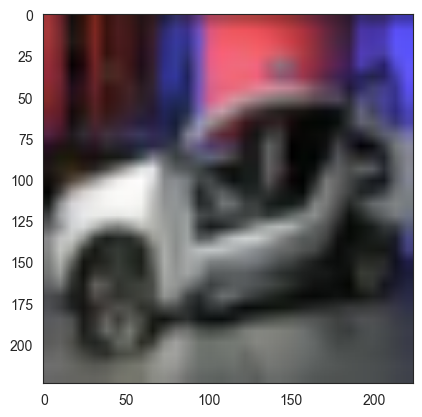

In [20]:
img_idx = 6
image = trainloader.dataset[img_idx][0]
print(image.shape)

sns.set_style("white")
visualize_tensor(image)

### 1.3 Train/Val Best Accuracy save

In [21]:
def get_best_accuracy(path):
    event_acc = EventAccumulator(path)
    event_acc.Reload()

    if 'scalars' in event_acc.Tags():
        scalar_tags = event_acc.Tags()['scalars']
        
        for i, tag in enumerate(scalar_tags):
            values = event_acc.Scalars(tag)
            max_value = max(v.value for v in values)
            min_value = min(v.value for v in values)
            if tag == 'Acc/train':
                best_train_acc = max_value
            elif tag == 'Acc/val':
                best_val_acc = max_value
            elif tag == 'Loss/train':
                best_train_loss = min_value
            elif tag == 'Loss/val':
                best_val_loss = min_value
    
    return best_train_acc, best_val_acc, best_train_loss, best_val_loss

In [22]:
# RECURSIVE run this!!!
BEST_VALUES = {}

for log_path in log_files :
    mode, model, dataset, freeze = name_parser(log_path)
    best_train_acc, best_val_acc, best_train_loss, best_val_loss = get_best_accuracy(log_path)
    alias = dataset+"-"+freeze
    BEST_VALUES[alias] = {'best_train_acc': best_train_acc, 'best_val_acc': best_val_acc, 'best_train_loss': best_train_loss, 'best_val_loss': best_val_loss}

prnt(BEST_VALUES)

╭──────────────┬─────────────────────────────────╮
│cifar100-10101│╭───────────────┬───────────────╮│
│              ││best_train_acc │88.492500305175││
│              ││               │78             ││
│              ││best_val_acc   │68.290000915527││
│              ││               │34             ││
│              ││best_train_loss│0.0054958821274││
│              ││               │34015          ││
│              ││best_val_loss  │0.0177789721637││
│              ││               │96425          ││
│              │╰───────────────┴───────────────╯│
│cifar100-10110│╭───────────────┬───────────────╮│
│              ││best_train_acc │88.602500915527││
│              ││               │34             ││
│              ││best_val_acc   │68.639999389648││
│              ││               │44             ││
│              ││best_train_loss│0.0054666465148││
│              ││               │329735         ││
│              ││best_val_loss  │0.0176286678761││
│              ││              

### 1.4 Train Log Print

In [ ]:
def draw_log(path, isSave=False, overlap=True):
    mode, model, dataset, freeze = name_parser(path)
    event_acc = EventAccumulator(path)
    event_acc.Reload()

    if 'scalars' in event_acc.Tags():
        scalar_tags = event_acc.Tags()['scalars']

        if not overlap :
            plt.figure(figsize=(13, 10))
            sns.set()

        for i, tag in enumerate(scalar_tags):
            values = event_acc.Scalars(tag)
            steps = [v.step for v in values]
            data = [v.value for v in values]
            
            df = pd.DataFrame({'Step': steps, tag: data})

            plt.subplot(2, 2, i + 1)
            sns.lineplot(x='Step', y=tag, data=df, label=dataset+"("+freeze+")" )
            plt.xlabel('Steps')
            plt.ylabel(tag)
            plt.title(f'{tag} over Time')
            
        plt.tight_layout()
        if not overlap :
            plt.show()

if not RECURSIVE :
    draw_log(log_path, SAVE)

else :
    plt.figure(figsize=(13, 10))
    sns.set()
    for log_path in log_files :
        draw_log(log_path, SAVE)
    plt.show()

# 2. Visualization

### 2.1. cnn Filter visualization
`visualize_filters` : 모델을 이루는 각각의 convolution 필터의 가중치를 시각화 합니다. (constraint: 1st channel)

In [24]:
from utils.visualize_tool import visualize_filters

In [25]:
layer_names = [name for name, _ in MODEL.named_modules()]
print(layer_names)

['', 'features', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


torch.Size([64, 3, 11, 11])


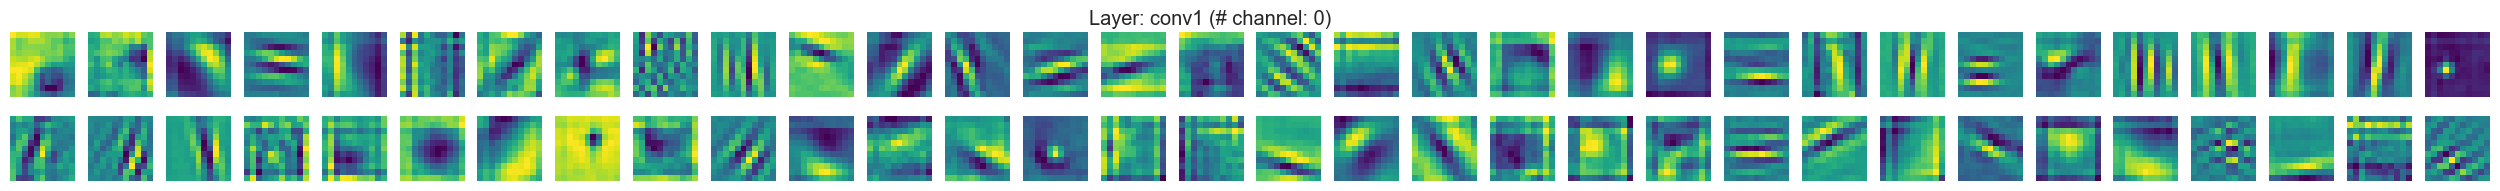

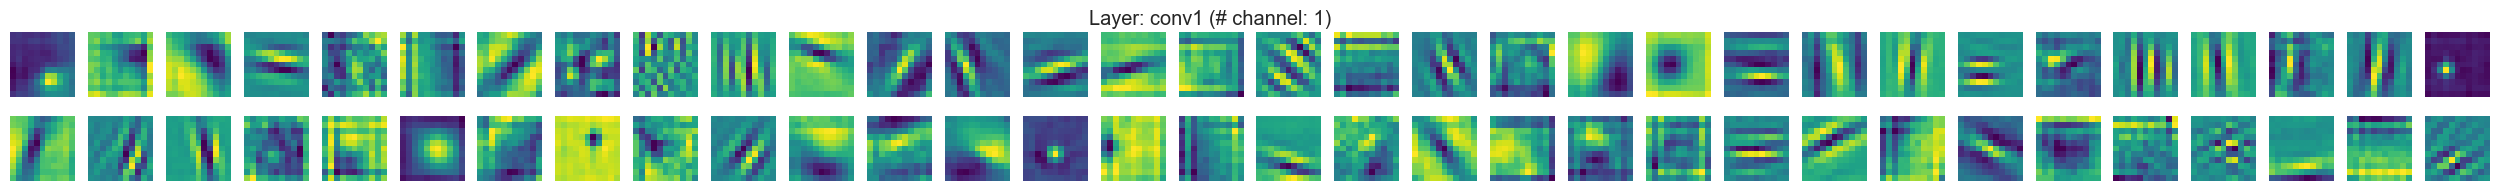

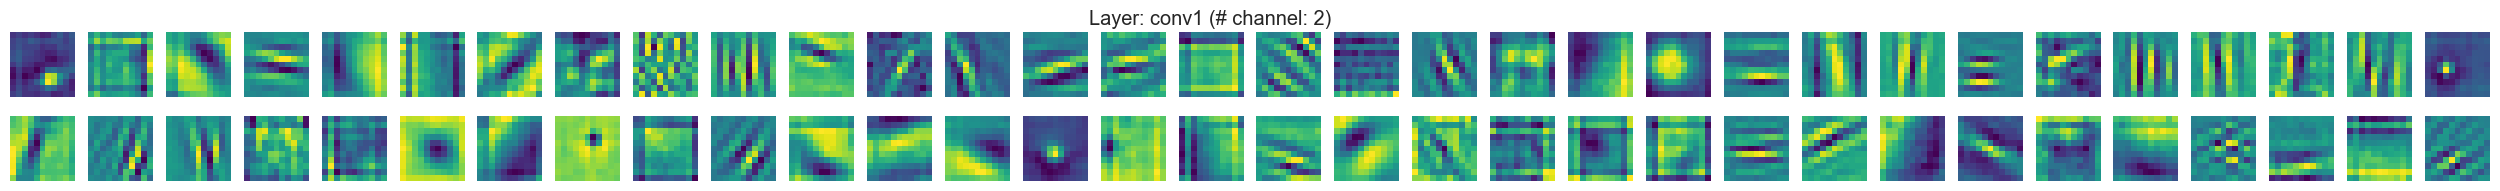

In [26]:
layer_name = "features.0"
visualize_filters(model_info, MODEL, layer_name, ncols=32, nchannel=5, showAll=False)

torch.Size([64, 3, 11, 11])


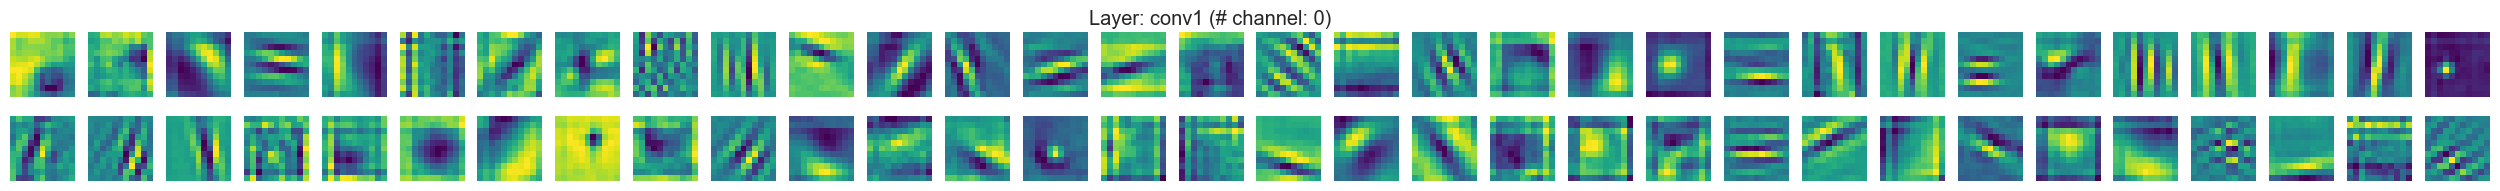

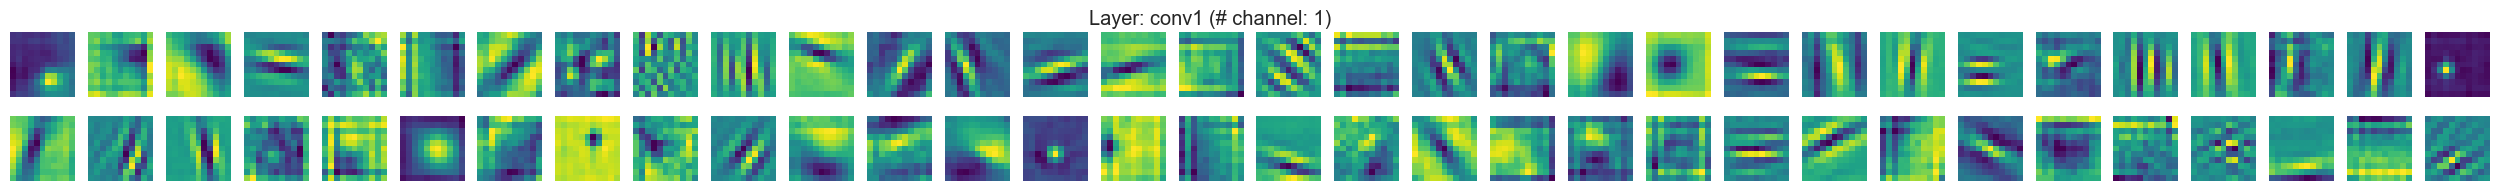

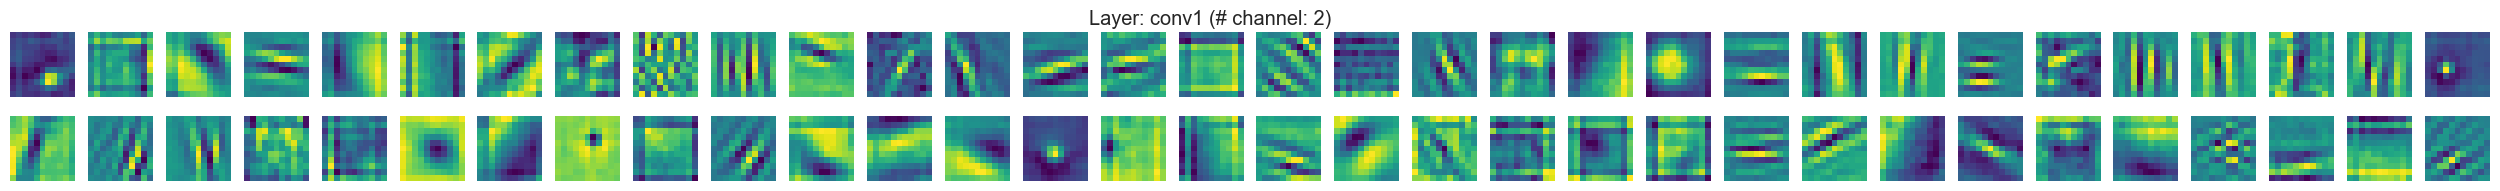

torch.Size([64, 3, 11, 11])


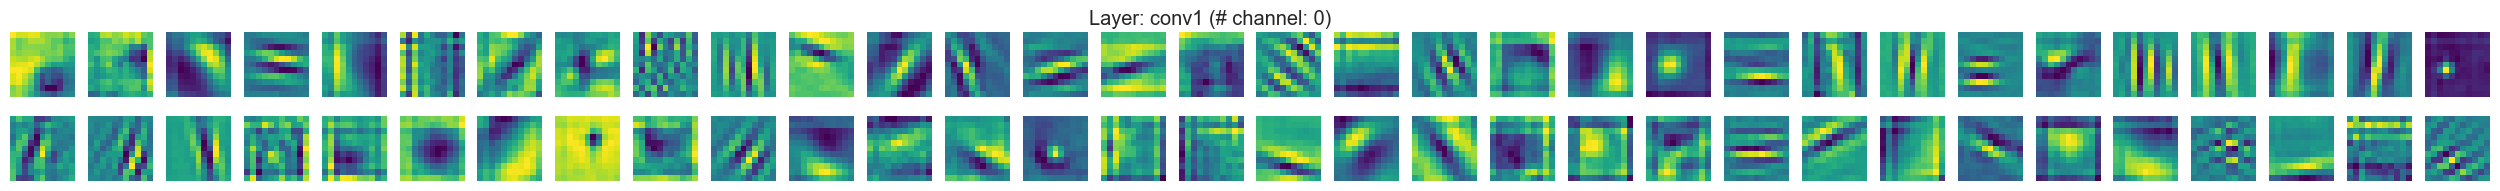

KeyboardInterrupt: 

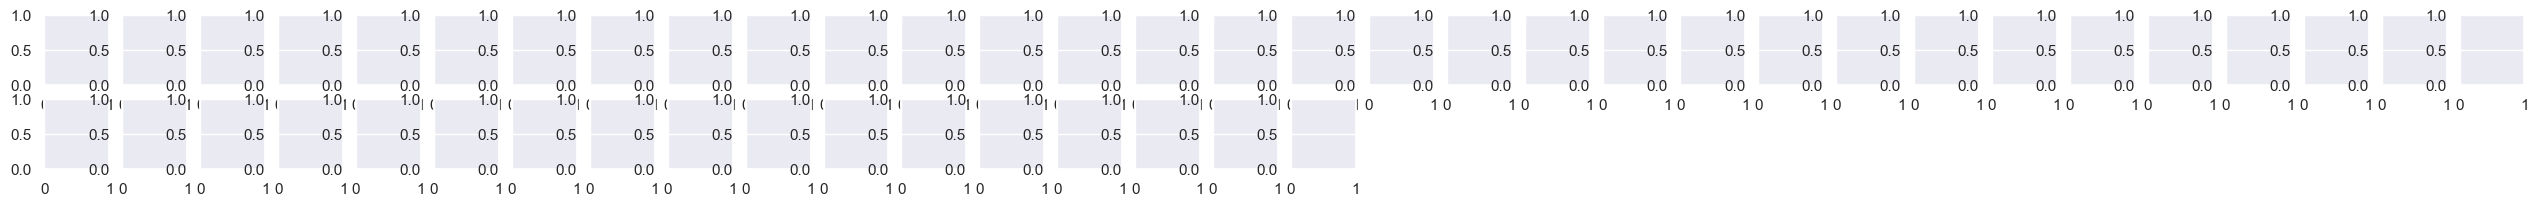

In [27]:
""" RECURSIVE : Running This!!! """
layer_name_list = ['features.0', 'features.3', 'features.6', 'features.8', 'features.10']

for name in layer_name_list :
    visualize_filters(model_info, MODEL, layer_name, ncols=32, nchannel=5, showAll=False)

### 2.2. Feature map Visualize
`visualize_feature_map` : 특정 입력 이미지에 대해 모델의 각 레이어를 통과했을 때 feature_map을 시각화 합니다. (constraint: 1st feature map)

torch.Size([192, 27, 27])


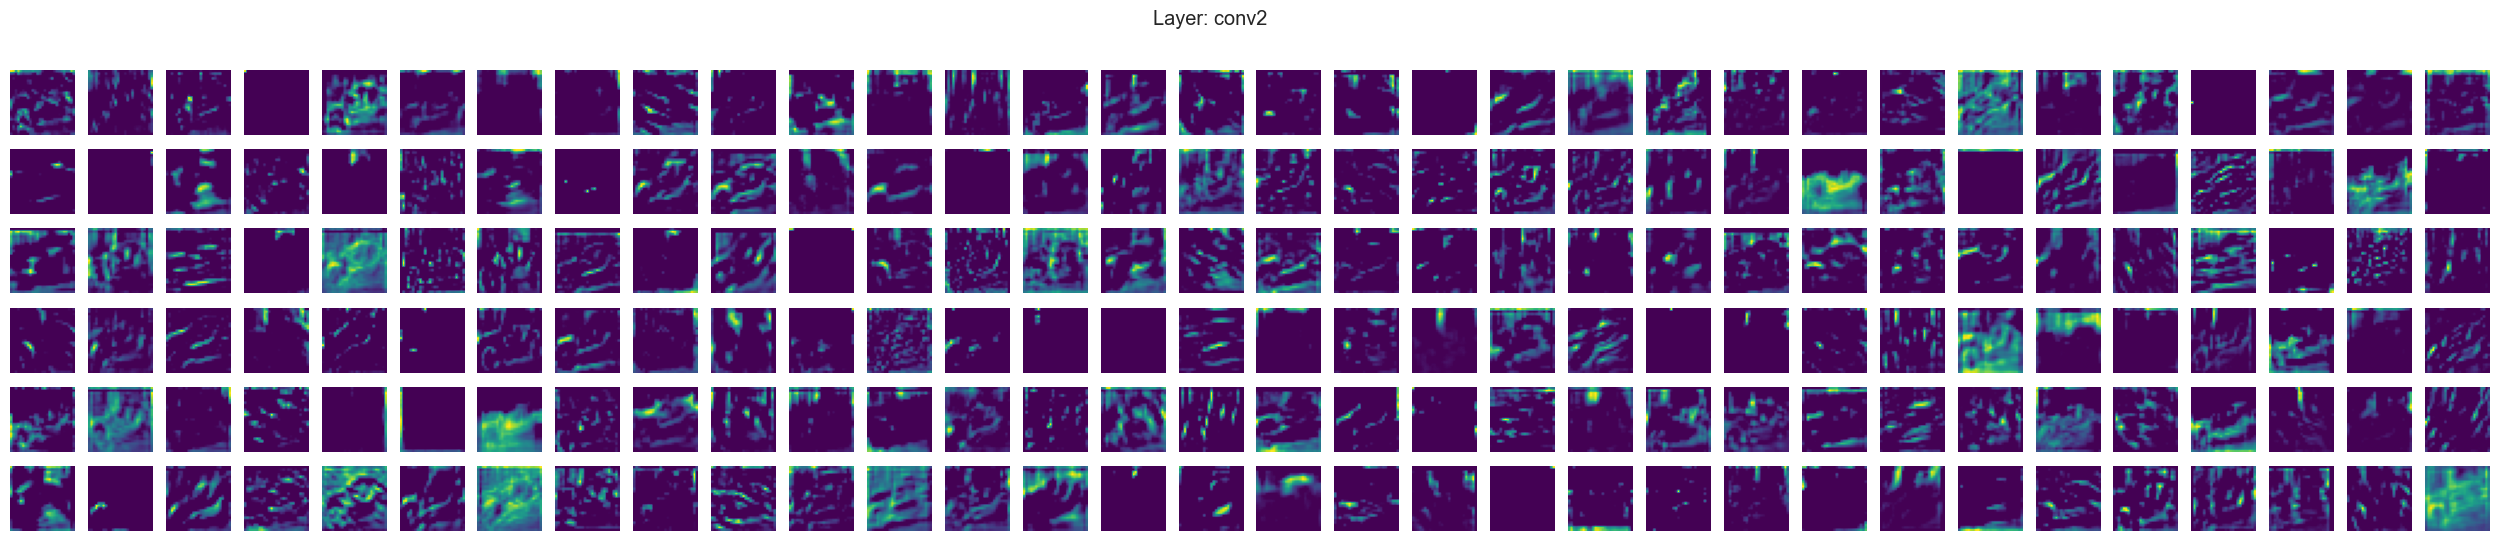

In [28]:
from utils.visualize_tool import visualize_feature_map

layer_name = 'conv2'
input_image = torch.unsqueeze(image, 0)

activation = {}
visualize_feature_map(activation, MODEL, input_image, layer_name, model_info[layer_name])

torch.Size([64, 55, 55])


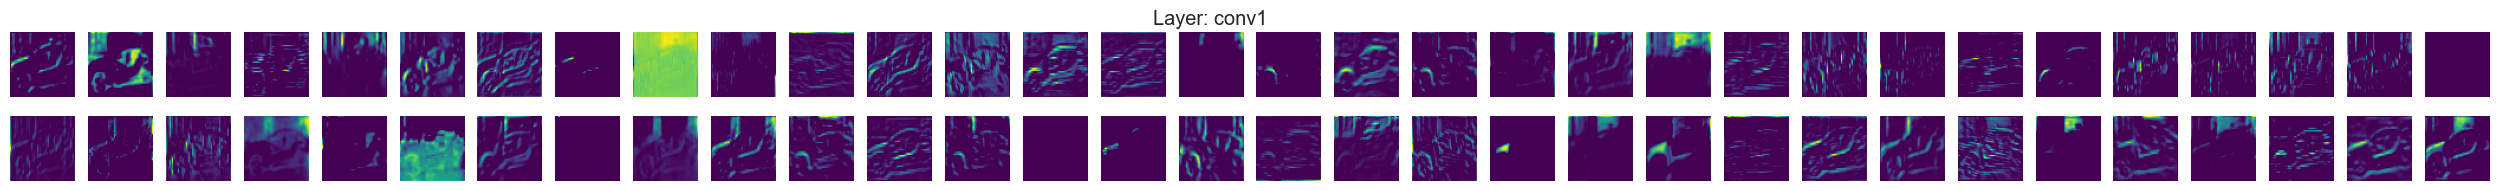

torch.Size([192, 27, 27])


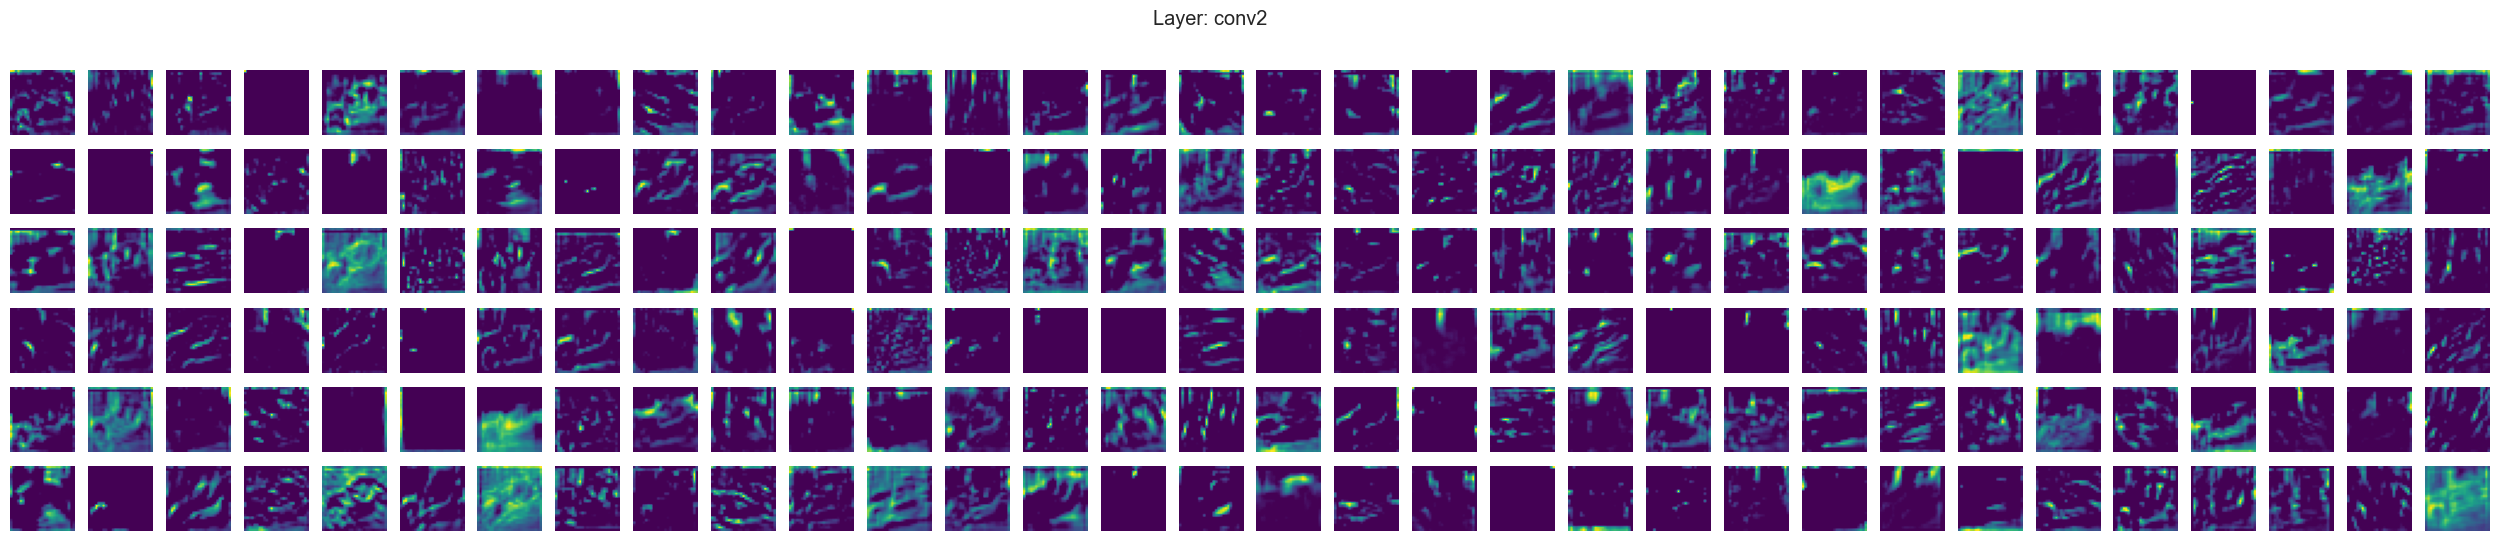

torch.Size([384, 13, 13])


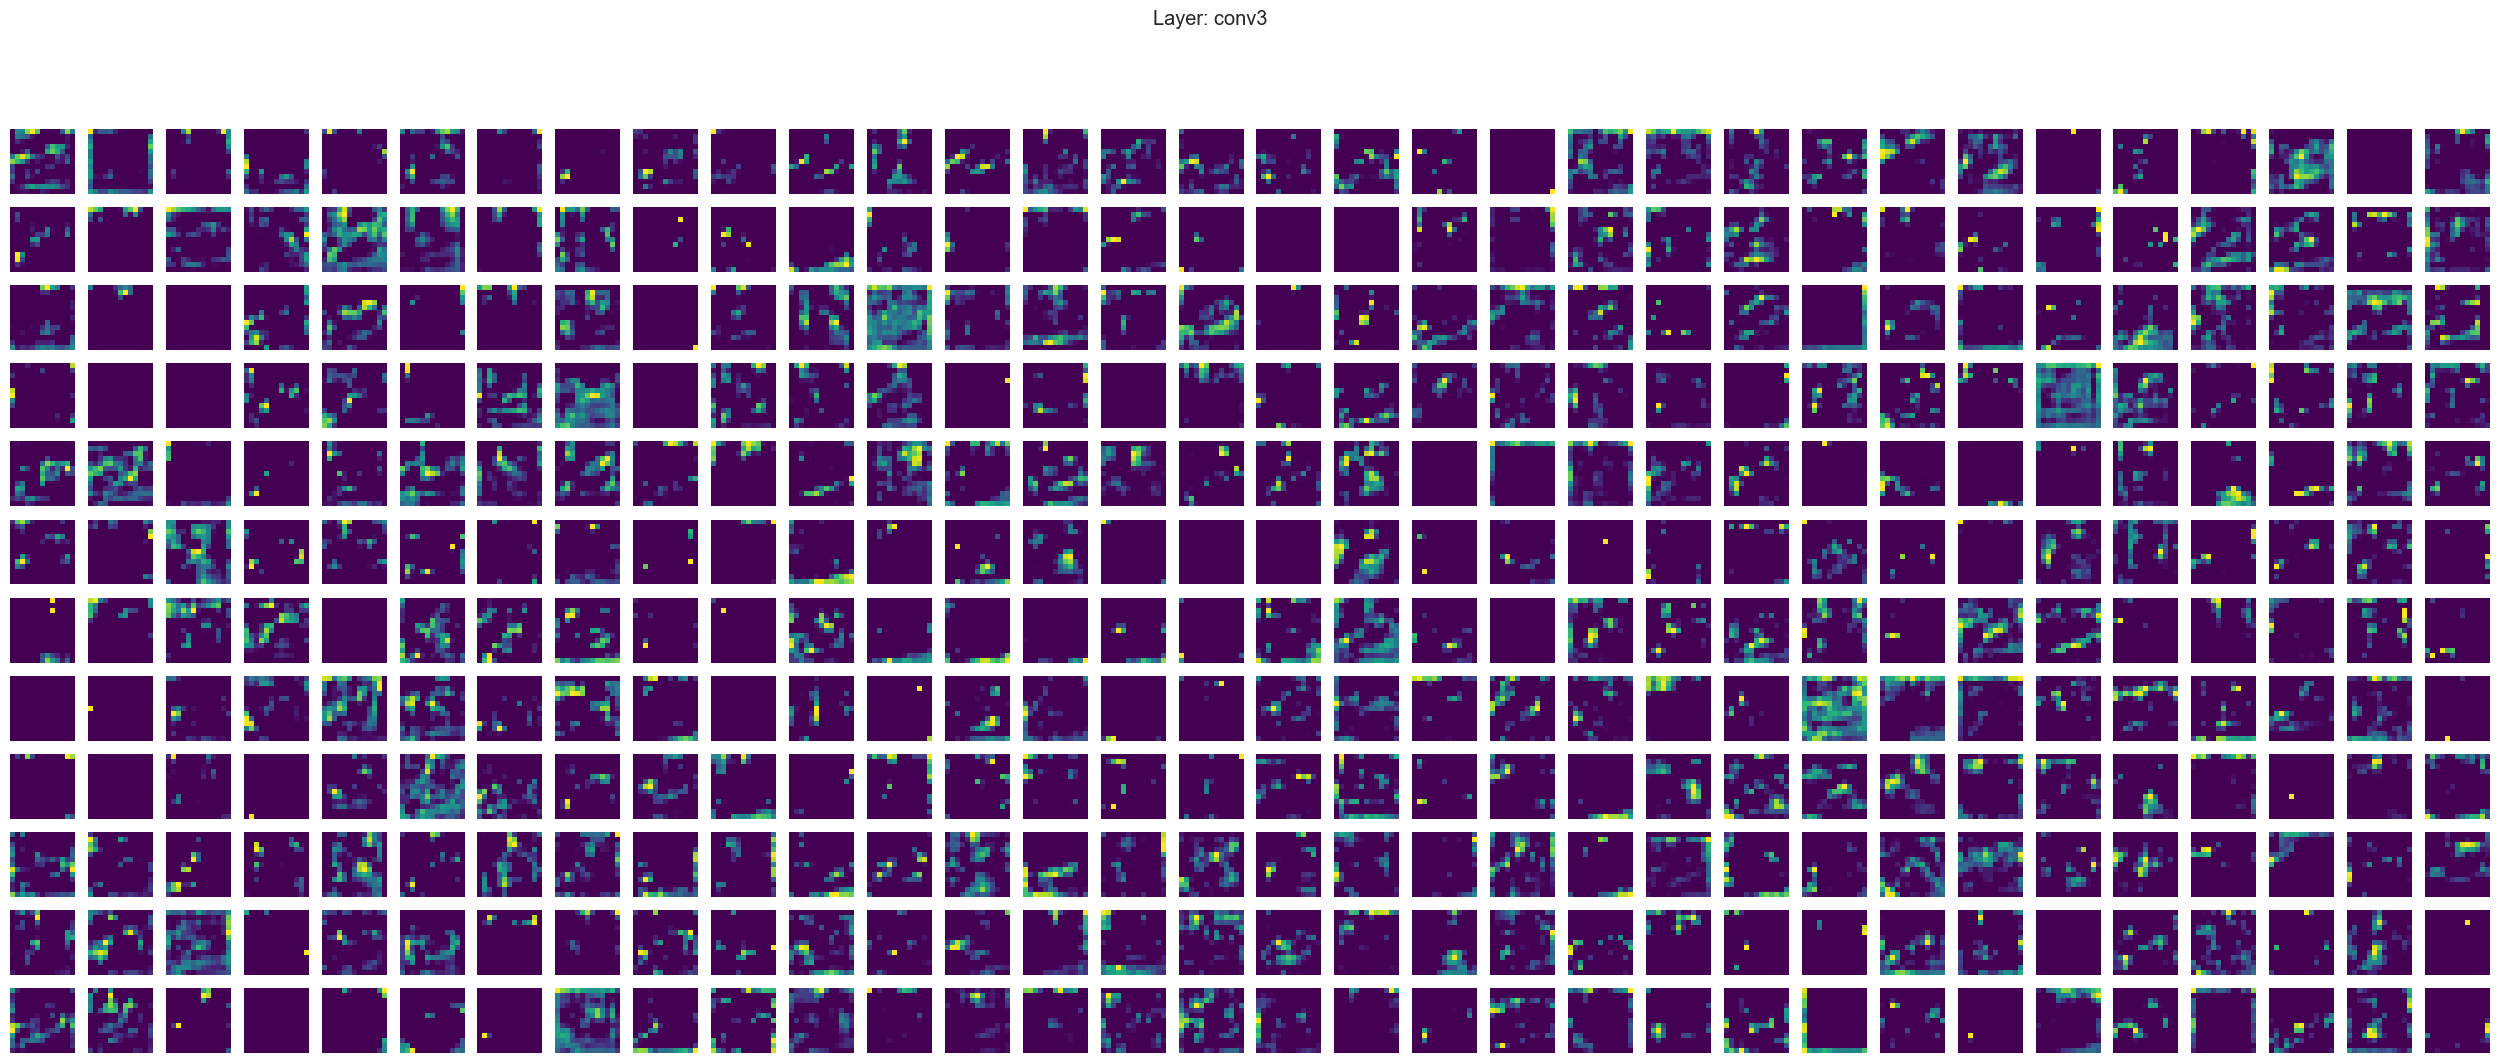

torch.Size([256, 13, 13])


KeyboardInterrupt: 

In [29]:
""" RECURSIVE : Running This!!! """
model_info = dict(
    conv1=0,
    conv2=3,
    conv3=6,
    conv4=8,
    conv5=10
)

input_image = torch.unsqueeze(image, 0)

for layer_name in model_info:
    activation = {}
    visualize_feature_map(activation, MODEL, input_image, layer_name, model_info[layer_name])

### 2.3. weight distribution (each layer)
`visualize_weight_distribution` : 모델을 이루는 각각의 레이어의 가중치 분포를 시각화 합니다. 

In [30]:
from utils.visualize_tool import visualize_weight_distribution

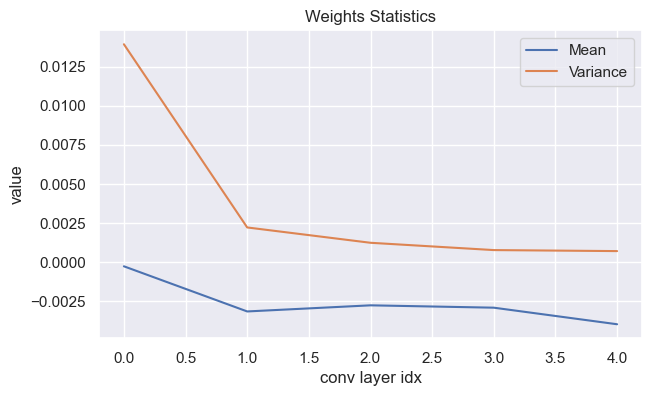

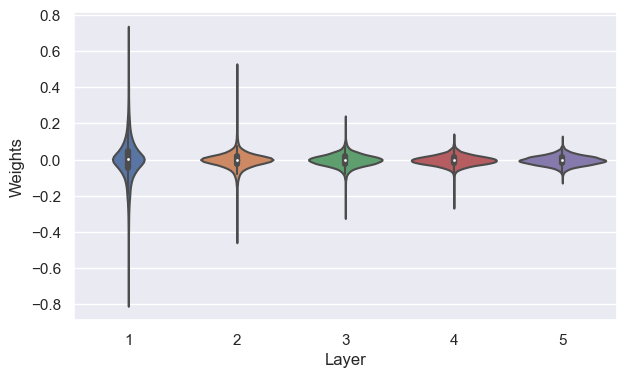

In [32]:
visualize_weight_distribution(MODEL, violin_sample=5000)

### 2.4. Dataset Distribution
`visualize_feature_distribution`: 모델이 판단하는 CLASS와 실제 정답 CLASS의 분포를 비교합니다.

In [33]:
from utils.get_data import get_feature_map

In [50]:
shuffle_testloader = DataLoader(testloader.dataset, batch_size=2000, shuffle=True)

In [84]:
features = []
labels = []
preds = []
layer_name = "conv5"

with torch.no_grad():
    MODEL.eval()
    count = 0
    for data, target in shuffle_testloader:
        count += 1
        activation = {}
        feature = get_feature_map(activation, MODEL, data, layer_name, model_info[layer_name])
        features = feature.view(2000, -1)
        labels = target
        output = MODEL(data)
        pred = output.argmax(dim=1, keepdim=True)
        preds = pred
        if count != 0 :
            break
        # test_loss += criterion(output, target).item()
        # test_acc += pred.eq(target.view_as(pred)).sum().item()

In [86]:
print(len(labels))
print(type(labels))
print(labels.shape)

2000
<class 'torch.Tensor'>
torch.Size([2000])


In [87]:
reducer = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.5, metric="cosine", random_state=50)

embedding = reducer.fit_transform(features)
print(embedding.shape)

(2000, 2)


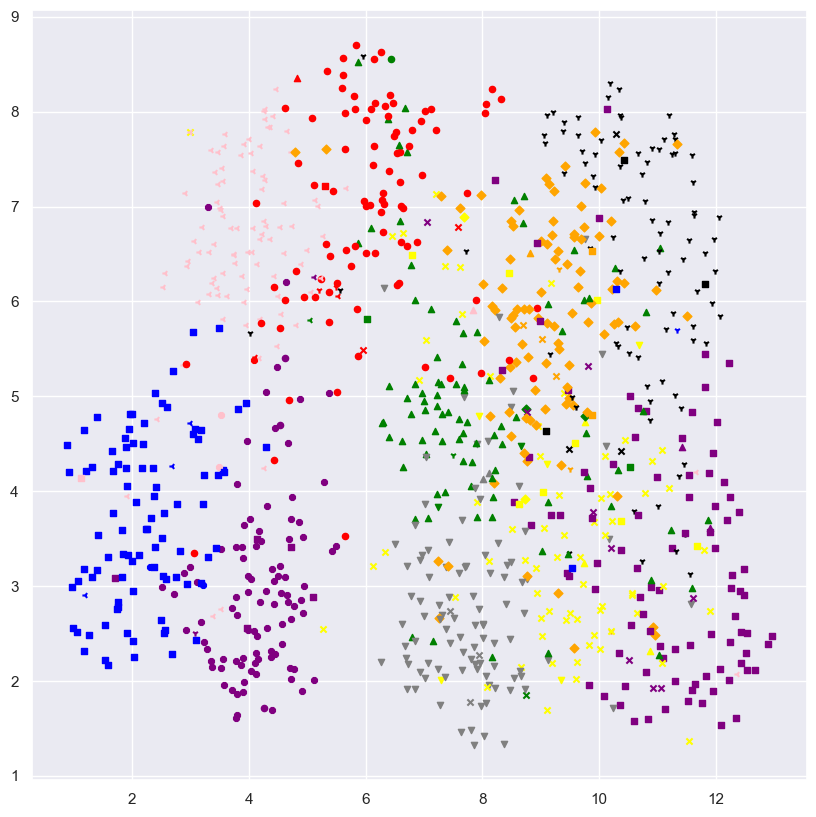

In [88]:
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'gray', 'black', 'pink', 'purple']
markers = ['o', 's', '^', 'x', 'D', ',', 'v', '1', '3', '8']

fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(111, projection='3d')

for i in range(embedding.shape[0]//2):
    # print(labels[i])
    plt.scatter(embedding[2*i+1, 0], embedding[2*i+1, 1], label=abs(labels[2*i+1]), marker=markers[labels[2*i+1]], color=colors[preds[2*i+1]], s=20) # origin
    
plt.show()


### 2.5. Gradient

**2.5.1 Layer-CAM**  
LayerCAM [16] is a simple modification of Grad-CAM [3], which can generate reliable class activation maps from different layers.  
``: 모델이 이미지를 분류할 떄, 어떤 부분에 집중하여 판단하는지를 함께 표현하여 시각화합니다.

In [38]:
from utils.visualize_tool import visualize_class_activation_images
from utils.visualize_grad import LayerCam

In [89]:
from utils.util_functions import get_info


img_idx = 2000

data =  trainloader.dataset[img_idx]
origin_img, prep_img, target_class = get_info(data)

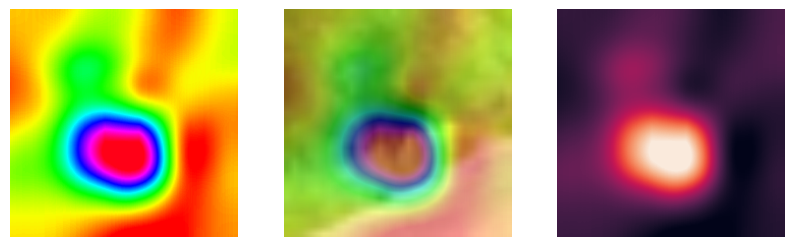

TypeError: an integer is required (got type Image)

In [93]:
layer_number = 12  # [0, 12]

layer_cam = LayerCam(MODEL, layer_number)
cam = layer_cam.generate_cam(prep_img, target_class)
visualize_class_activation_images(origin_img, cam, dataset, freeze, layer_number)

sns.set_style("white")
visualize_tensor(data[0])

In [45]:
"""ITERATIVE run this!!!!"""
for i in range(13):
    layer_cam = LayerCam(model, i)
    cam = layer_cam.generate_cam(prep_img, target_class)
    visualize_class_activation_images(origin_img, cam, dataset, freeze, i, save=SAVE, show=False)
print('Layer cam completed')

AttributeError: 'str' object has no attribute 'eval'

In [47]:
print(MODEL)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

**2.5.2 Grad Times Image**  
Another technique that is proposed is simply multiplying the gradients with the image itself.  
``: 모델이 주어진 이미지를 볼 때, 계산된 Gradient와 원본이미지의 곱으로 나타낸 그림을 시각화합니다.

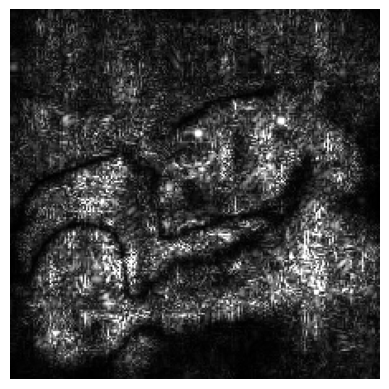

Grad times image completed.


In [48]:
from utils.visualize_tool import visualize_gradXimage
from utils.util_functions import get_info

data =  trainloader.dataset[img_idx]
origin_img, prep_img, target_class = get_info(data)

visualize_gradXimage(prep_img, target_class, MODEL, dataset, freeze, show=True, save=False)

# 3. Comparison

### 3.1. Train Accuracy
- ``: 각 데이터셋 마다 layer freezing에 따른 train accuracy를 비교합니다.
- ``: 각 layer freezing마다 데이터셋에 따른 train accuracy를 비교합니다.

### 3.2. Test Accuracy
- ``: 각 데이터셋 마다 layer freezing에 따른 test accuracy를 비교합니다.
- ``: 각 layer freezing마다 데이터셋에 따른 test accuracy를 비교합니다.